In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import math
import os
from tensorflow import keras
import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
# from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [3]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg" or ftype == ".jpeg":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

In [4]:
benign = np.array(Dataset_loader('/content/drive/MyDrive/research/skin_cancer/train_data/train/benign',224))
malignant = np.array(Dataset_loader('/content/drive/MyDrive/research/skin_cancer/train_data/train/malignant',224))

100%|██████████| 3026/3026 [01:02<00:00, 48.08it/s] 


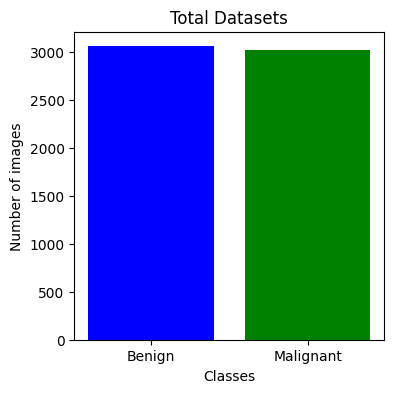

In [ ]:
dataset_lengths = [len(benign), len(malignant)]
datasets = ['Benign', 'Malignant']

# Plot
plt.figure(figsize=(4, 4))
plt.bar(datasets, dataset_lengths, color=['blue', 'green'])
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.title('Total Datasets')
plt.show()

In [ ]:
print(len(benign))
benign.shape

3060


(3060, 224, 224, 3)

In [5]:
# Create labels
benign_label = np.zeros(len(benign))
malignant_label = np.ones(len(malignant))

In [6]:
# Merge data
X_train = np.concatenate((benign, malignant), axis = 0)
Y_train = np.concatenate((benign_label, malignant_label), axis = 0)

In [7]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

In [8]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

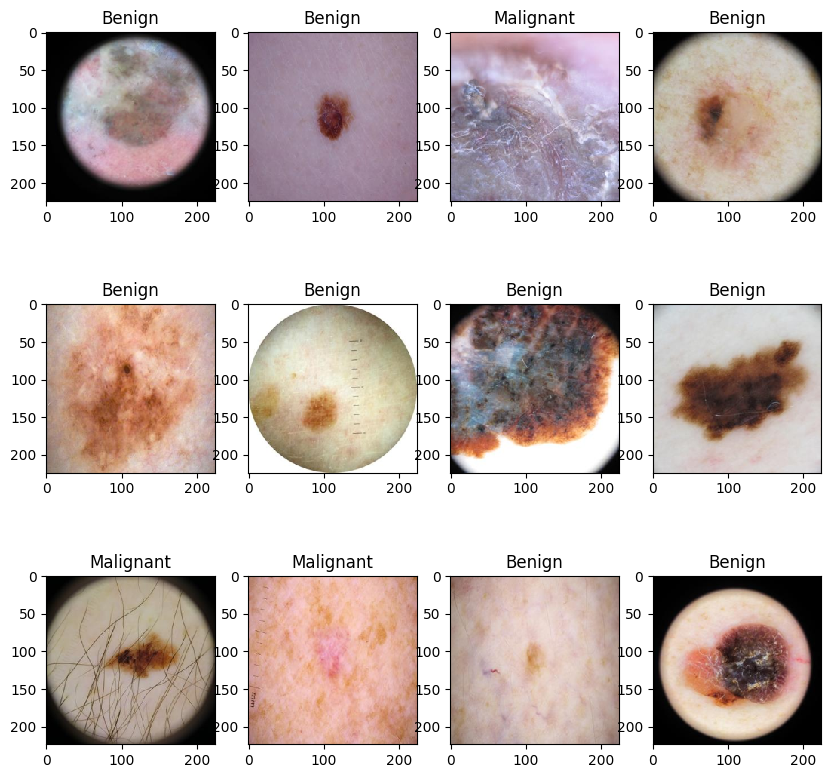

In [ ]:
# # Display first 12 images of moles, and how they are classified
# # Here IDC (+) means Benign
# # IDC (-) means Malignant
w=60
h=40
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [10]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images
    )

total_original_images = len(x_train)
augmentation_factor = 6
total_augmented_images = total_original_images * augmentation_factor

print("Total number of training images:", total_original_images)
print("Total number of augmented training images:", total_augmented_images)

Total number of training images: 4868
Total number of augmented training images: 29208


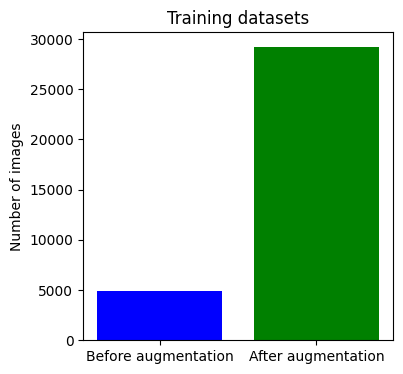

In [11]:
dataset_lengths = [total_original_images, total_augmented_images]
datasets = ['Before augmentation', 'After augmentation']

# Plot
plt.figure(figsize=(4, 4))
plt.bar(datasets, dataset_lengths, color=['blue', 'green'])
plt.ylabel('Number of images')
plt.title('Training datasets')
plt.show()

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

xception      = Xception(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
inception      = InceptionV3(include_top=False, input_shape=input_shape)(inputs)

In [ ]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(xception), GlobalAveragePooling2D()(inception)])
# Concatenate(axis=-1)([GlobalAveragePooling2D()(vgg), GlobalAveragePooling2D()(nas)])
outputs = BatchNormalization()(outputs)
outputs = Dense(32,activation='relu')(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 xception (Functional)       (None, 7, 7, 2048)           2086148   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 inception_v3 (Functional)   (None, 5, 5, 2048)           2180278   ['input_1[0][0]']             
                                                          4                                       
                                                                                              

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Driveweights.multinet.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=22,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-20-904993e46bf8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/22
153/152 [==============================] - ETA: 0s - loss: 0.2927 - accuracy: 0.8778

152/152 [==============================] - 158s 825ms/step - loss: 0.2927 - accuracy: 0.8778 - val_loss: 0.2464 - val_accuracy: 0.9146 - lr: 1.0000e-04
Epoch 2/22
153/152 [==============================] - ETA: 0s - loss: 0.2204 - accuracy: 0.9133

152/152 [==============================] - 113s 738ms/step - loss: 0.2204 - accuracy: 0.9133 - val_loss: 0.2399 - val_accuracy: 0.9039 - lr: 1.0000e-04
Epoch 3/22
153/152 [==============================] - ETA: 0s - loss: 0.1959 - accuracy: 0.9246

152/152 [==============================] - 116s 762ms/step - loss: 0.1959 - accuracy: 0.9246 - val_loss: 0.1699 - val_accuracy: 0.9376 - lr: 1.0000e-04
Epoch 4/22
153/152 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.9326

152/152 [==============================] - 116s 758ms/step - loss: 0.1804 - accuracy: 0.9326 - val_loss: 0.2528 - val_accuracy: 0.8974 - lr: 1.0000e-04
Epoch 5/22
153/152 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.9390

152/152 [==============================] - 116s 762ms/step - loss: 0.1641 - accuracy: 0.9390 - val_loss: 0.1689 - val_accuracy: 0.9368 - lr: 1.0000e-04
Epoch 6/22
153/152 [==============================] - ETA: 0s - loss: 0.1548 - accuracy: 0.9447

152/152 [==============================] - 116s 760ms/step - loss: 0.1548 - accuracy: 0.9447 - val_loss: 0.1734 - val_accuracy: 0.9425 - lr: 1.0000e-04
Epoch 7/22
153/152 [==============================] - ETA: 0s - loss: 0.1396 - accuracy: 0.9509

152/152 [==============================] - 116s 758ms/step - loss: 0.1396 - accuracy: 0.9509 - val_loss: 0.1868 - val_accuracy: 0.9384 - lr: 1.0000e-04
Epoch 8/22
153/152 [==============================] - ETA: 0s - loss: 0.1451 - accuracy: 0.9447

152/152 [==============================] - 117s 762ms/step - loss: 0.1451 - accuracy: 0.9447 - val_loss: 0.1757 - val_accuracy: 0.9442 - lr: 1.0000e-04
Epoch 9/22
153/152 [==============================] - ETA: 0s - loss: 0.1159 - accuracy: 0.9604

152/152 [==============================] - 112s 742ms/step - loss: 0.1159 - accuracy: 0.9604 - val_loss: 0.1843 - val_accuracy: 0.9351 - lr: 1.0000e-04
Epoch 10/22
153/152 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.9540

152/152 [==============================] - 116s 762ms/step - loss: 0.1253 - accuracy: 0.9540 - val_loss: 0.1951 - val_accuracy: 0.9351 - lr: 1.0000e-04
Epoch 11/22
153/152 [==============================] - ETA: 0s - loss: 0.1065 - accuracy: 0.9618

152/152 [==============================] - 113s 743ms/step - loss: 0.1065 - accuracy: 0.9618 - val_loss: 0.1741 - val_accuracy: 0.9409 - lr: 1.0000e-04
Epoch 12/22
153/152 [==============================] - ETA: 0s - loss: 0.1002 - accuracy: 0.9645

152/152 [==============================] - 116s 759ms/step - loss: 0.1002 - accuracy: 0.9645 - val_loss: 0.1986 - val_accuracy: 0.9351 - lr: 1.0000e-04
Epoch 13/22
153/152 [==============================] - ETA: 0s - loss: 0.1043 - accuracy: 0.9604

152/152 [==============================] - 116s 760ms/step - loss: 0.1043 - accuracy: 0.9604 - val_loss: 0.1895 - val_accuracy: 0.9384 - lr: 1.0000e-04
Epoch 14/22
153/152 [==============================] - ETA: 0s - loss: 0.0823 - accuracy: 0.9712

152/152 [==============================] - 116s 758ms/step - loss: 0.0823 - accuracy: 0.9712 - val_loss: 0.1877 - val_accuracy: 0.9409 - lr: 1.0000e-04
Epoch 15/22
153/152 [==============================] - ETA: 0s - loss: 0.1043 - accuracy: 0.9622

152/152 [==============================] - 116s 761ms/step - loss: 0.1043 - accuracy: 0.9622 - val_loss: 0.1984 - val_accuracy: 0.9401 - lr: 1.0000e-04
Epoch 16/22
153/152 [==============================] - ETA: 0s - loss: 0.0845 - accuracy: 0.9698

152/152 [==============================] - 116s 763ms/step - loss: 0.0845 - accuracy: 0.9698 - val_loss: 0.2154 - val_accuracy: 0.9310 - lr: 1.0000e-04
Epoch 17/22
153/152 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9729

152/152 [==============================] - 116s 758ms/step - loss: 0.0808 - accuracy: 0.9729 - val_loss: 0.2013 - val_accuracy: 0.9409 - lr: 1.0000e-04
Epoch 18/22
153/152 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9751

152/152 [==============================] - 113s 738ms/step - loss: 0.0723 - accuracy: 0.9751 - val_loss: 0.2161 - val_accuracy: 0.9368 - lr: 1.0000e-04
Epoch 19/22
153/152 [==============================] - ETA: 0s - loss: 0.0774 - accuracy: 0.9731

152/152 [==============================] - 113s 741ms/step - loss: 0.0774 - accuracy: 0.9731 - val_loss: 0.1949 - val_accuracy: 0.9417 - lr: 1.0000e-04
Epoch 20/22
153/152 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.9784

152/152 [==============================] - 116s 763ms/step - loss: 0.0676 - accuracy: 0.9784 - val_loss: 0.2042 - val_accuracy: 0.9401 - lr: 1.0000e-04
Epoch 21/22
153/152 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.9790

152/152 [==============================] - 116s 758ms/step - loss: 0.0643 - accuracy: 0.9790 - val_loss: 0.2106 - val_accuracy: 0.9425 - lr: 1.0000e-04
Epoch 22/22
153/152 [==============================] - ETA: 0s - loss: 0.0595 - accuracy: 0.9793

152/152 [==============================] - 116s 762ms/step - loss: 0.0595 - accuracy: 0.9793 - val_loss: 0.2444 - val_accuracy: 0.9409 - lr: 1.0000e-04


39/39 [==============================] - 9s 179ms/step
Confusion matrix, without normalization
[[616  10]
 [ 62 530]]


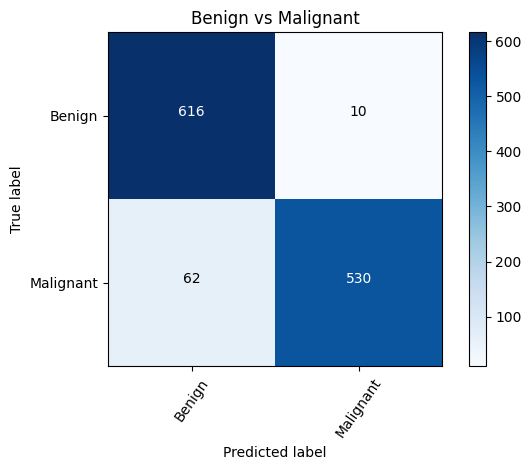

In [ ]:
Y_pred = model.predict(x_val)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['Benign', 'Malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Benign vs Malignant')

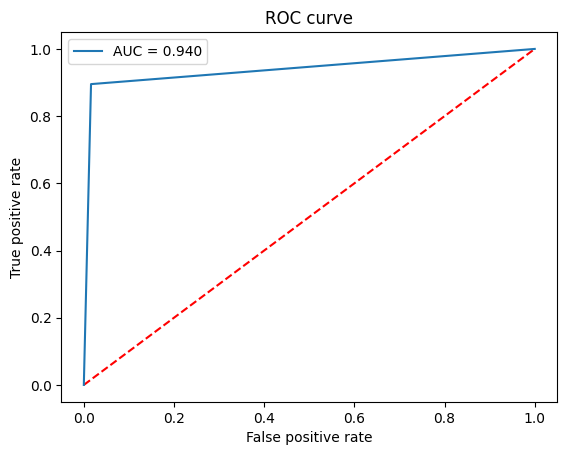

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
# roc_log = roc_auc_score(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

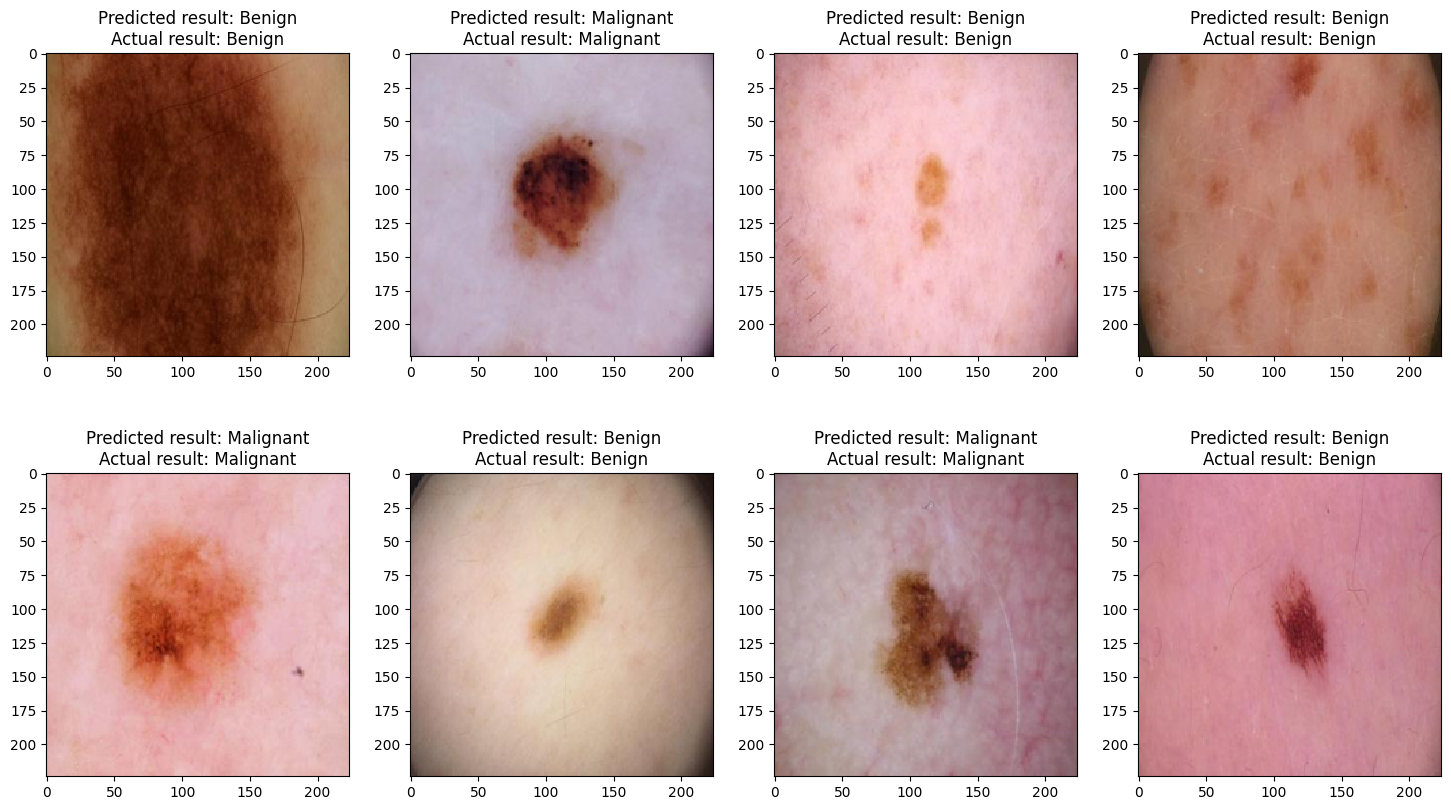

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_val)):
    if(np.argmax(y_val[i])==np.argmax(Y_pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_val)):
    if(not np.argmax(y_val[i])==np.argmax(Y_pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result: "+ Transfername(np.argmax(Y_pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(y_val[prop_class[i]])))
    plt.imshow(x_val[prop_class[i]], interpolation='nearest')
plt.show()

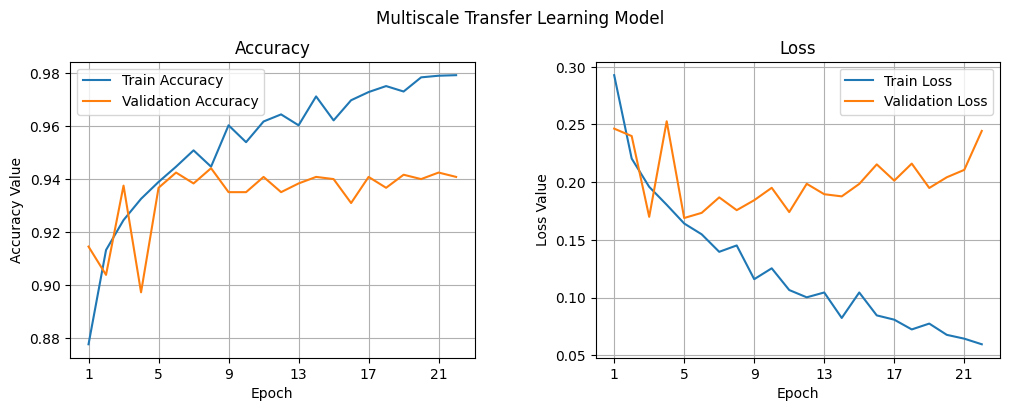

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Multiscale Transfer Learning Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,23))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 23, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 23, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
pred=model.predict(x_val)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(y_val,1)

39/39 [==============================] - 7s 182ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['Benign', 'Malignant']
print(classification_report(y_test, Y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Benign       0.91      0.98      0.94       626
   Malignant       0.98      0.90      0.94       592

    accuracy                           0.94      1218
   macro avg       0.95      0.94      0.94      1218
weighted avg       0.94      0.94      0.94      1218



In [ ]:
# def preprocess_input_image(image_path):
#     img = np.asarray(Image.open(image_path).convert("RGB"))
#     img = cv2.resize(img, (224, 224))
#     img = np.array(img)
#     return img

# input_image = np.array(preprocess_input_image('/content/drive/My Drive/research/skin_cancer/test/benign/1.jpg'))

# input_image_reshape = input_image.reshape(1, 224, 224, 3)

# pred=model.predict(input_image_reshape)
# input_pred = np.argmax(pred, 1)

# if input_pred[0] == 0:
#   plt.title('Not Melanoma')
# else:
#   plt.title('Melanoma')

# plt.imshow(input_image)
# plt.show()

In [ ]:
# from google.colab import files
# #Train and save your model
# model = model
# model.save('/content/drive/My Drive/research/skin_cancer/final_skin_cancer_multinet_incep_xception_94.h5')

# files.download('/content/drive/My Drive/research/skin_cancer/final_skin_cancer_multinet_incep_xception_94.h5')